The PyNE ```mesh``` module provides generic mesh creation and manipulation capabilities. Both Cartesian and tetrahedral mesh are supported. PyNE meshes can be tagged with scalar and vector quantities and also PyNE `Material` objects. Tagged data can all be easily accessed with a common syntax.

Under the hood, the PyNE `Mesh` class is a wrapper around a [MOAB](https://press3.mcs.anl.gov/sigma/moab-library) mesh.
A `Mesh` object stores a mesh instance, and additionally a PyNE `MaterialLibrary` object (to map PyNE `Material`s to mesh volume elements).

The notebook will provide some basic examples of PyNE mesh usage. First let's import the necessary components of PyNE and a few other things that will be explained in this notebook:


#### Known error: This notebook requires [yt](https://yt-project.org/) to visualize the results. Yt needs to be updated to work properly first. Updates are currently being made to yt's frontends to make this PyNE integration work.

In [25]:
# Import some classes from pyne.mesh
from pyne.mesh import Mesh, NativeMeshTag, MetadataTag, ComputedTag
from pyne.material import Material, from_atom_frac
from pyne.xs.channels import sigma_t
import numpy as np

# import plotting utilities
from yt.config import ytcfg; ytcfg["yt","suppressStreamLogging"] = "True"
from yt.frontends.moab.api import PyneMoabHex8Dataset
from yt.mods import SlicePlot

# Basics

Let's make a simple Cartesian mesh that is 4 x 3 x 1:

In [249]:
coords = [[0, 1, 2, 3, 4], [0, 1, 2, 3], [0,1]]
m = Mesh(structured=True, structured_coords=coords) # here "structured" means Cartesian

Tags -- sometimes known as fields -- are a way of storing data on a mesh. Both scalar and vector quantities can be tagged on each volume element of the mesh using PyNE NativeMeshTags. Here we create a scalar, floating point tag to describe the neutron flux on a mesh:

In [250]:
m.neutron_flux = NativeMeshTag(size=1, dtype=float)

Some fictitious neutron flux data can now be applied to the mesh:

In [251]:
m.neutron_flux[:] = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0]

PyNE meshes are supported by the [yt project](http://yt-project.org/).  Here we use yt's plotting infrastructure to display the mesh tag that was just created:


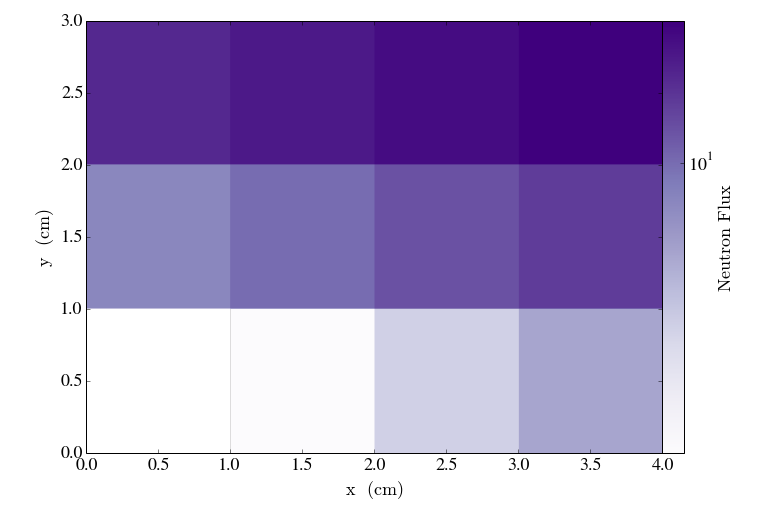

In [252]:
pf = PyneMoabHex8Dataset(m)
s = SlicePlot(pf, 'z', 'neutron_flux', origin='native')
s.set_cmap('neutron_flux', 'Purples')
s.display()

The volume elements within the mesh are kept track of using the volume element index (`i`). The volume element index is defined on the range from 0 (inclusive) to the number of volumes in the mesh (exclusive).

The flux for the volume element `i=7` can be retrieved (and similarly set) using the following syntax:

In [253]:
m.neutron_flux[7]

14.0

"Fancy" indexing can be used. This means that multiple indicies can be provided, yielding the tag value for each:

In [254]:
m.neutron_flux[2, 3, 4]

array([ 4.,  6.,  8.])

Masking can be used to return only values that match some criteria. Here we request all flux values above 10.0:

In [255]:
m.neutron_flux[m.neutron_flux[:] >= 10.0]

array([ 10.,  12.,  14.,  16.,  18.,  20.,  22.])

# PyNE Mesh + PyNE Materials

PyNE meshes can natively store PyNE `Material` objects. This can be used to represent discretized versions of geometries. First we create a new mesh, `m2`, that is a slightly larger mesh than our previous example. This one is 9x9x1:

In [2]:
coords2 = [np.linspace(0,9,10), np.linspace(0,9,10), [0, 10]]
m2 = Mesh(structured=True, structured_coords=coords2)

Create a few materials that will be assigned to the mesh:

In [3]:
fuel = from_atom_frac({'U235': 0.045, 'U238': 0.955, 'O16': 2.0}, density=10.7)
mod = from_atom_frac({'H1': 2.0, 'O16': 1.0}, density=1.0)

Loop through the mesh and assign materials in a reactor-like pattern:

In [4]:
for i in range(len(m2)):
    if (i+1)%2 != 0 and np.floor((i)/9)%2 != 0:
        m2.mats[i] = fuel
    else:    
        m2.mats[i] = mod

Plot the density. Here the fuel appears red (high density) and the moderator appears blue (low density).


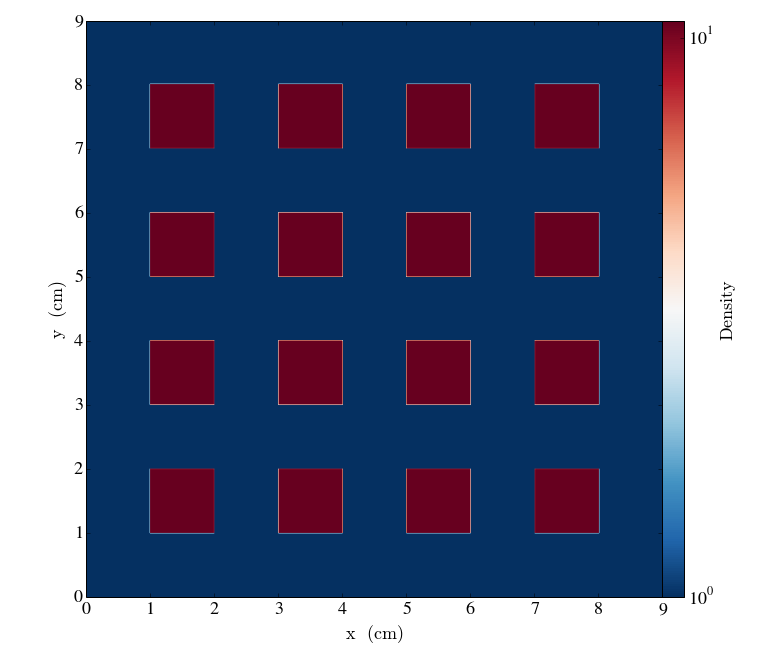

In [5]:
pf2 = PyneMoabHex8Dataset(m2)
s2 = SlicePlot(pf2, 'z', 'density', origin='native')
s2.set_cmap('density', 'RdBu_r')
s2.display()

The materials that we've added to the mesh can be accesssed via the same syntax used for NativeMeshTags. The material on the the mesh volume element with index `i=12` is retrieved:

In [235]:
m2.mats[12]

pyne.material.Material({80160000: 0.11852241570586383, 922350000: 0.03918773177732002, 922380000: 0.8422898525168162}, 269.905309039, 10.7, 3.0, {})

The attributes of this material can be accessed:

In [234]:
m2.mats[12].density

10.7

Equivalently the density can be accessed via the generic tag syntax:

In [223]:
m2.density[3]

1.0

The same is true of the composition of the material (another attribute of the `Material` class):

In [6]:
m2.comp[3]

{10010000: 0.11191487328808077, 80160000: 0.8880851267119192}

In fact, all `Material` attributes are treated as tags. A list of all tags, including these material properties treated as tags is shown here:

In [266]:
m2.tags.keys()

['sub_act',
 'expand_elements',
 'number_density',
 'sub_tru',
 'idx',
 'density',
 'comp',
 'atoms_per_molecule',
 'to_atom_frac',
 'sub_lan',
 'molecular_mass',
 'mass',
 'sub_fp',
 'mult_by_mass',
 'sub_ma',
 'mass_density',
 'metadata']

# Advanced Feature: Computed Tags

Computed tags (also known as "derived fields") are a way of creating a "virtual" tag. That is, computed tags to not require tag data to be actually stored on the mesh, or even computed ahead of time. When data is requested from a computed tag, it is calculated and returned on-the-fly (this is known as "lazy evaluation"). This convenient feature when dealing with extremely large data.

A computed tag is defined with a function, lambda (a.k.a an "anonymous" function), or any other callable object. The function must have the following interface:

```python
def f(mesh, i):
    """mesh is a pyne.mesh.Mesh() object and i is the volume element index
    to compute.
    """
    # ... do some work ...
    return anything_you_want
```

Computed tags are probably best-understood through example. Here is a simple, somewhat silly example that creates a computed tag `i_plus_density` which is simply the sum of the mesh volume element index `i` and density:

In [7]:
m2.i_plus_density = ComputedTag(lambda mesh, i: i + mesh.density[i])

Plotting `i_plus_density`:


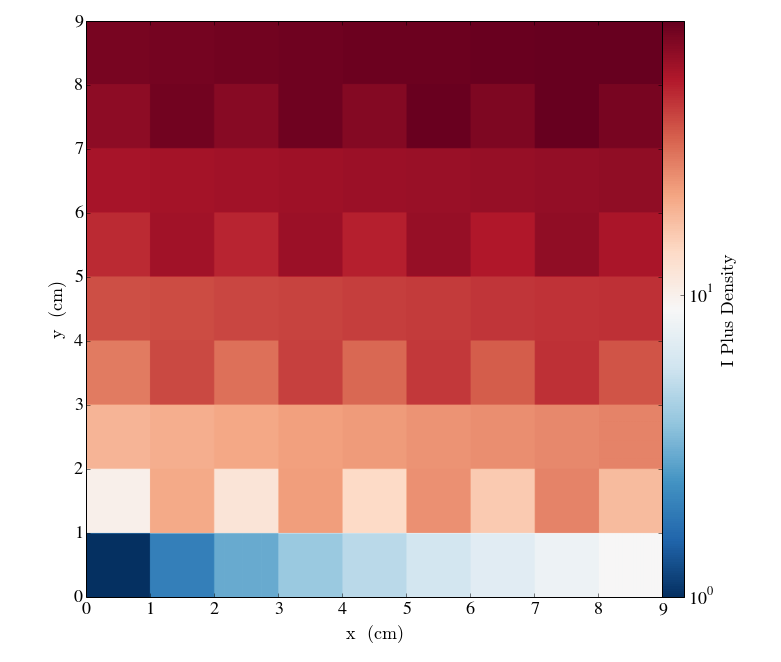

In [285]:
pf3 = PyneMoabHex8Dataset(m2)
s3 = SlicePlot(pf3, 'z', 'i_plus_density', origin='native')
s3.set_cmap('i_plus_density', 'RdBu_r')
s3.display()

Here is a more serious example which uses PyNE's cross section tools to compute the one-group total cross section $\sigma_t$ everywhere on the mesh.

In [288]:
m2.sigma_t = ComputedTag(lambda mesh, i: sigma_t(mesh.mats[i], group_struct=[10.0, 1e-6], phi_g=[1.0])[0])


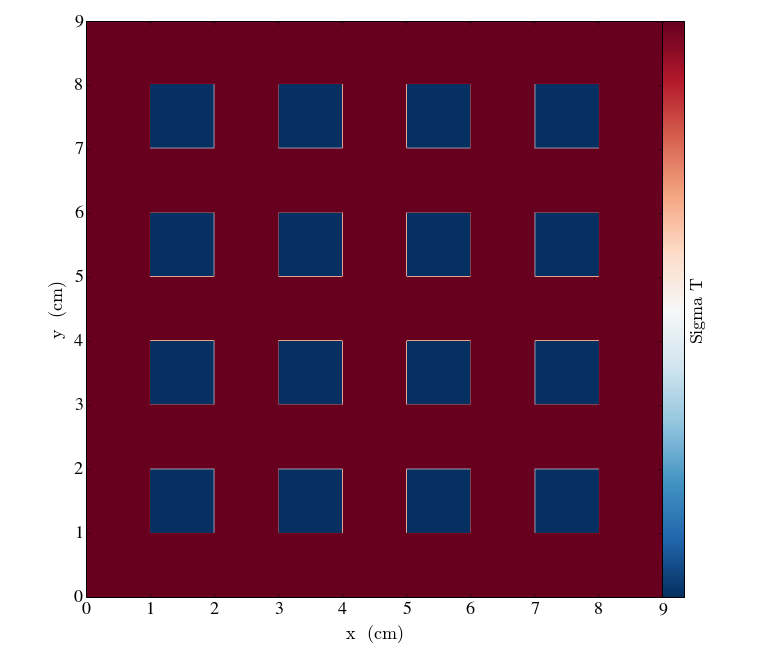

In [291]:
pf4 = PyneMoabHex8Dataset(m2)
s4 = SlicePlot(pf4, 'z', 'sigma_t', origin='native')
s4.set_cmap('sigma_t', 'RdBu_r')
s4.display()

This plot shows that the one-group total cross section is highest in the moderater -- all from a computed tag generated in one line of code!